<a href="https://colab.research.google.com/github/jorbanegas/labo2025ros/blob/main/Comparando_experimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparando experimentos colaborativos


En este colab se presentan visualizaciones y test sobre el experimento colaborativo que trata sobre la inclusión de los meses de pandemia.

#### **1 Seteo del ambiente en Google Colab**

Esta parte se debe correr con el runtime en Python3
<br>Ir al menu, Runtime -> Change Runtime Type -> Runtime type ->  **Python 3**

Conectar la virtual machine donde esta corriendo Google Colab con el  Google Drive, para poder tener persistencia de archivos

In [ ]:
# primero establecer el Runtime de Python 3
from google.colab import drive
drive.mount('/content/.drive')

Mounted at /content/.drive


In [ ]:
%%shell

mkdir -p "/content/.drive/My Drive/labo1"
mkdir -p "/content/buckets"
ln -s "/content/.drive/My Drive/labo1" /content/buckets/b1

mkdir -p ~/.kaggle
cp /content/buckets/b1/kaggle/kaggle.json  ~/.kaggle
chmod 600 ~/.kaggle/kaggle.json


mkdir -p /content/buckets/b1/exp
mkdir -p /content/buckets/b1/datasets
mkdir -p /content/datasets


webfiles="https://storage.googleapis.com/open-courses/austral2025-af91/labo1r"
destino_local="/content/datasets"
destino_bucket="/content/buckets/b1/datasets"


archivo="dataset_pequeno.csv"

if ! test -f $destino_bucket/$archivo; then
  wget  $webfiles/$archivo  -O $destino_bucket/$archivo
fi


if ! test -f $destino_local/$pequeno; then
  cp  $destino_bucket/$archivo  $destino_local/$archivo
fi

#-------

archivo="gerencial_competencia_2025.csv.gz"

if ! test -f $destino_bucket/$archivo; then
  wget  $webfiles/$archivo  -O $destino_bucket/$archivo
fi


if ! test -f $destino_local/$pequeno; then
  cp  $destino_bucket/$archivo  $destino_local/$archivo
fi


# Lectura de Experimentos

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Type -> Runtime type -> R

limpio el ambiente de R

In [ ]:
format(Sys.time(), "%a %b %d %X %Y")

[1] "Sun Jul 06 05:08:18 PM 2025"

In [ ]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,659546,35.3,1454437,77.7,1454437,77.7
Vcells,1225561,9.4,8388608,64.0,1975128,15.1


In [ ]:
require("data.table")

if( !require("R.utils")) install.packages("R.utils")
require("R.utils")

Loading required package: data.table

Loading required package: R.utils

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘R.utils’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘R.oo’, ‘R.methodsS3’


Loading required package: R.utils

Loading required package: R.oo

Loading required package: R.methodsS3

R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.27.1 (2025-05-02 21:00:05 UTC) successfully loaded. See ?R.oo for help.


Attaching package: ‘R.oo’


The following object is masked from ‘package:R.methodsS3’:

    throw


The following objects are masked from ‘package:methods’:

    getClasses, getMethods


The following objects are masked from ‘package:base’:

    attach, detach, load, save


R.utils v2.13.0 (2025-02-24 21:20:02 UTC) successfully loaded. See ?R.utils for help.




In [ ]:
PARAM <- list()
PARAM$dataset <- "gerencial_competencia_2025.csv.gz"

In [ ]:
# carpeta de trabajo

setwd("/content/buckets/b1/exp")
experimento_folder <- paste0("WF", PARAM$experimento)
dir.create(experimento_folder, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento_folder ))

In [ ]:
library(data.table)
library(ggplot2)
library(stringr)
install.packages(c("viridis","plotly"))
library(viridis)
library(plotly)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gridExtra’, ‘lazyeval’, ‘crosstalk’


Loading required package: viridisLite


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout




In [ ]:
base_path <- "/content/buckets/b1/exp"

In [ ]:
carpetas <- list.dirs(path = base_path, recursive = FALSE, full.names = TRUE)

# Incluir solo las carpetas que contienen "Colaborativo" pero NO "bis"
carpetas <- carpetas[grepl("Colaborativo", carpetas) & !grepl("bis", carpetas) & !grepl(("7|8|9|10"), carpetas)]

In [ ]:
carpetas

[1] "/content/buckets/b1/exp/WFColaborativo-1"
[2] "/content/buckets/b1/exp/WFColaborativo-2"
[3] "/content/buckets/b1/exp/WFColaborativo-3"
[4] "/content/buckets/b1/exp/WFColaborativo-4"
[5] "/content/buckets/b1/exp/WFColaborativo-5"
[6] "/content/buckets/b1/exp/WFColaborativo-6"

In [ ]:
resultados <- list()

In [ ]:
for (carpeta in carpetas) {
  archivos <- list.files(path = carpeta, pattern = "^prediccion_\\d+\\.txt$", full.names = TRUE)

  for (archivo in archivos) {
    pred <- fread(archivo)
    pred <- pred[order(-prob)]

    pred[, Ganancia := ifelse(clase_ternaria == "BAJA+2", 117000, -3000)]
    pred[, Ganancia_acum := cumsum(Ganancia)]

    cortes <- seq(200, 6000, 50)
    pred_cortes <- pred[cortes, .(envios = cortes, Ganancia_acum)]

    pred_cortes[, semilla := str_extract(basename(archivo), "\\d+")]
    pred_cortes[, exp := basename(carpeta)]

    resultados[[length(resultados) + 1]] <- pred_cortes
  }
}

# Combinar resultados
curvas <- rbindlist(resultados)

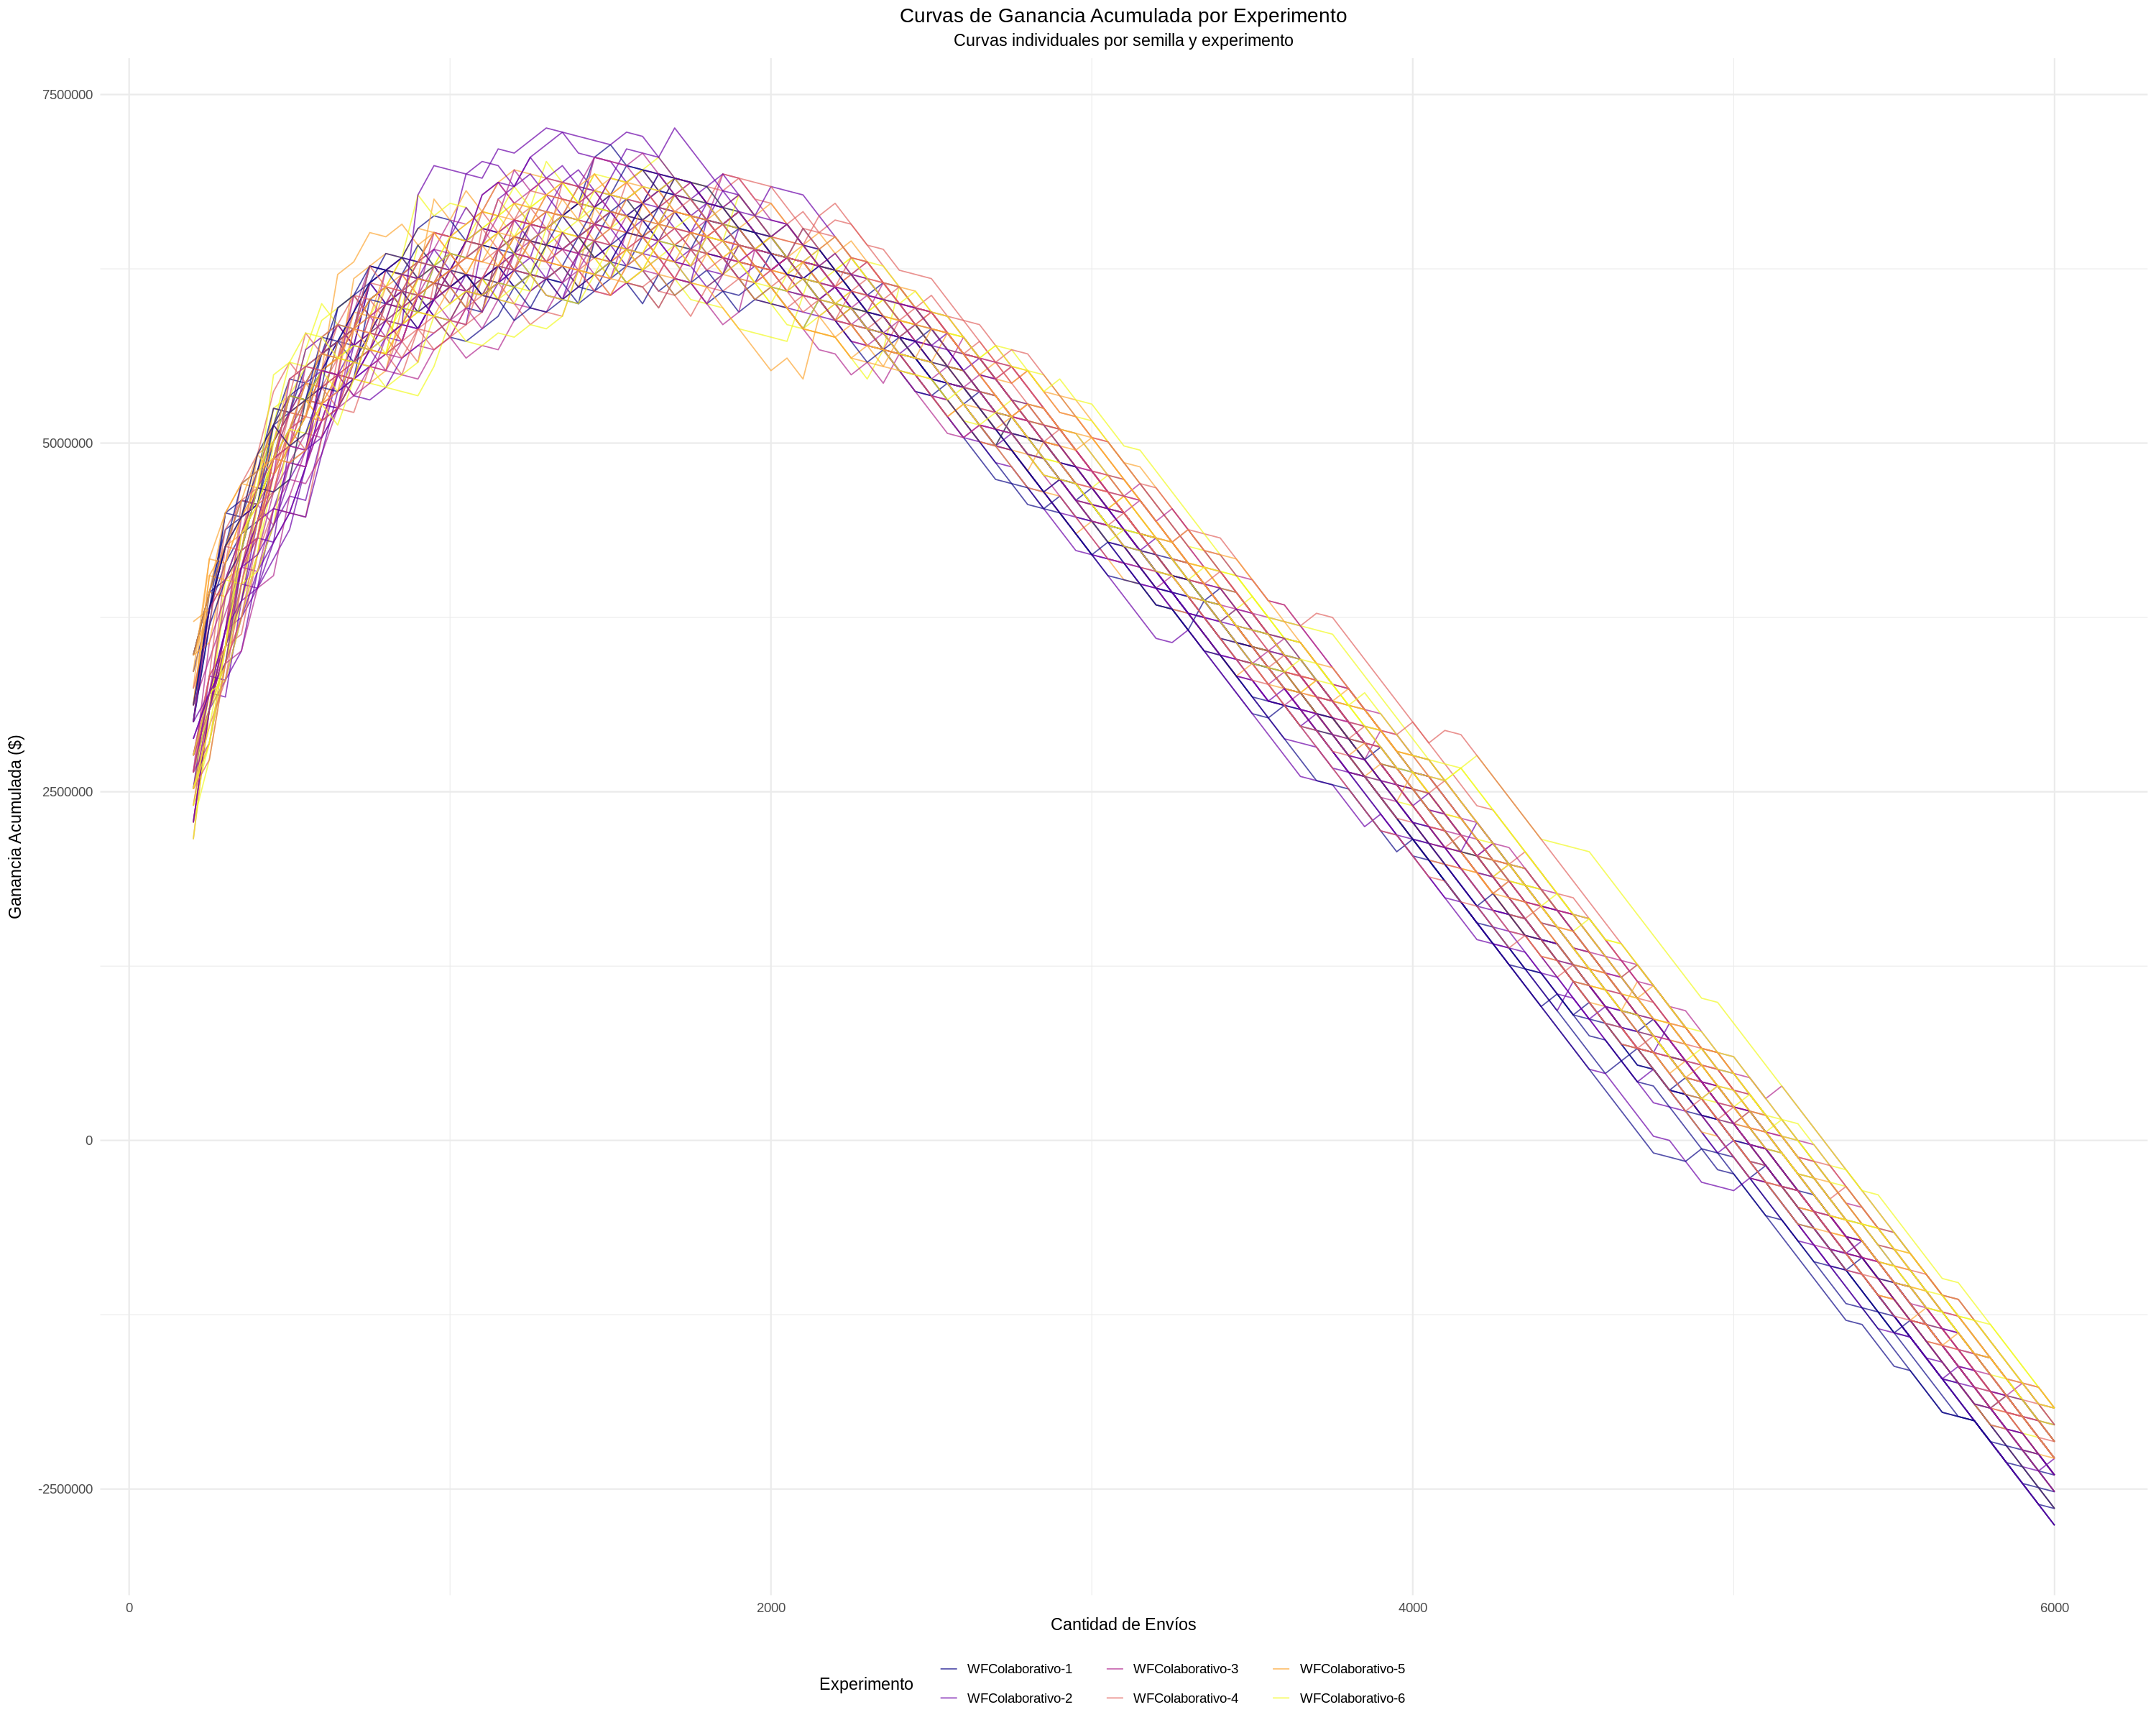

In [ ]:
ggplot(curvas, aes(x = envios, y = Ganancia_acum, color = exp, group = interaction(exp, semilla))) +
  geom_line(alpha = 0.7) +
  scale_color_viridis_d(option = "C") +
  labs(
    title = "Curvas de Ganancia Acumulada por Experimento",
    subtitle = "Curvas individuales por semilla y experimento",
    x = "Cantidad de Envíos",
    y = "Ganancia Acumulada ($)",
    color = "Experimento"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5),
    plot.subtitle = element_text(hjust = 0.5),
    legend.position = "bottom"
  )
  options(repr.plot.width = 25, repr.plot.height = 20)

In [ ]:
curvas_promedio <- curvas[, .(Ganancia_acum_mean = mean(Ganancia_acum)), by = .(exp, envios)]


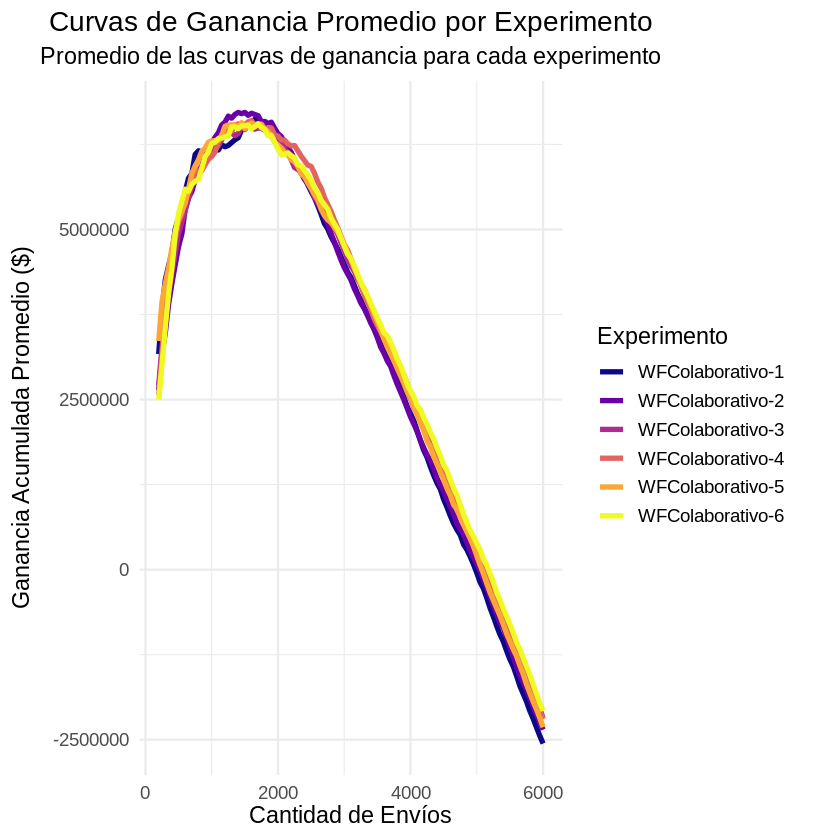

In [ ]:
ggplot(curvas_promedio, aes(x = envios, y = Ganancia_acum_mean, color = exp)) +
  geom_line(linewidth = 1.5) +
  scale_color_viridis_d(option = "C") +
  labs(
    title = "Curvas de Ganancia Promedio por Experimento",
    subtitle = "Promedio de las curvas de ganancia para cada experimento",
    x = "Cantidad de Envíos",
    y = "Ganancia Acumulada Promedio ($)",
    color = "Experimento"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5),
    plot.subtitle = element_text(hjust = 0.5)
  )

options(repr.plot.width = 25, repr.plot.height = 20)

#Wilcoxon

El test de Wilcoxon se hace entre pares de experimentos, comparando la ganancia por semilla. El argumento paired = TRUE, se supone que los valores comparados vienen de las mismas semillas, pero evaluadas en diferentes meses (según el experimento.

In [ ]:
cutoff_envios <- 2000

In [ ]:
paired_data <- curvas[envios == cutoff_envios & grepl("^WFColaborativo-", exp)]


In [ ]:
wide_data <- dcast(paired_data, semilla ~ exp, value.var = "Ganancia_acum")


In [ ]:
paired_data <- wide_data
target <- "WFColaborativo-1" #comparamos con el experimento que incluye todos los meses, incluso la pandemia
otros <- setdiff(names(paired_data), c("semilla", target))

resultados <- data.table(
  Comparacion = character(),
  p_value = numeric()
)

for (exp in otros) {
  test <- suppressWarnings(
    wilcox.test(paired_data[[target]], paired_data[[exp]], paired = TRUE)
  )

  resultados <- rbind(resultados, data.table(
    Comparacion = paste0(target, " vs ", exp),
    p_value = test$p.value
  ))
}

resultados[, `:=` (
  Comparacion = gsub("WFColaborativo-", "", Comparacion),
  p_value = round(p_value, 4),
  Significativo = ifelse(p_value < 0.05, "✔️ Sí", "❌ No")
)]

resultados <- resultados[order(p_value)]
print(resultados)


   Comparacion p_value Significativo
        <char>   <num>        <char>
1:      1 vs 6  0.1390         ❌ No
2:      1 vs 2  0.1593         ❌ No
3:      1 vs 5  0.5721         ❌ No
4:      1 vs 4  0.6364         ❌ No
5:      1 vs 3  0.8564         ❌ No


**Ninguna de las comparaciones muestra una diferencia estadísticamente significativa a un nivel de significación del 5%.**



Vemos que los p-values de 1 vs 6 y 1 vs 2 están más cerca de 0.05. Esto sugiere que podría haber una diferencia leve entre el Experimento 1 y los Experimentos 6 y 2, pero la evidencia no es suficiente. Podría probarse aumentar el número de semillas.

# **Nuevos experimentos**

Como básicamente estamos probando meses de entrenamiento, nos preguntamos, ¿siempre la ganancia es similar?¿En algún mes empeora?¿Con menos meses da lo mismo?

In [ ]:
# carpeta de trabajo

setwd("/content/buckets/b1/exp")
experimento_folder <- paste0("WF", PARAM$experimento)
dir.create(experimento_folder, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento_folder ))

In [ ]:
base_path <- "/content/buckets/b1/exp"

In [ ]:
carpetas <- list.dirs(path = base_path, recursive = FALSE, full.names = TRUE)

# Incluir solo las carpetas que contienen "Colaborativo" pero NO "bis"
carpetas <- carpetas[grepl("Colaborativo", carpetas) & !grepl("bis", carpetas) & grepl(("1|7|8|9|10"), carpetas)]

In [ ]:
resultados <- list()

In [ ]:
for (carpeta in carpetas) {
  archivos <- list.files(path = carpeta, pattern = "^prediccion_\\d+\\.txt$", full.names = TRUE)

  for (archivo in archivos) {
    pred <- fread(archivo)
    pred <- pred[order(-prob)]

    pred[, Ganancia := ifelse(clase_ternaria == "BAJA+2", 117000, -3000)]
    pred[, Ganancia_acum := cumsum(Ganancia)]

    cortes <- seq(200, 6000, 50)
    pred_cortes <- pred[cortes, .(envios = cortes, Ganancia_acum)]

    pred_cortes[, semilla := str_extract(basename(archivo), "\\d+")]
    pred_cortes[, exp := basename(carpeta)]

    resultados[[length(resultados) + 1]] <- pred_cortes
  }
}

# Combinar resultados
curvas <- rbindlist(resultados)

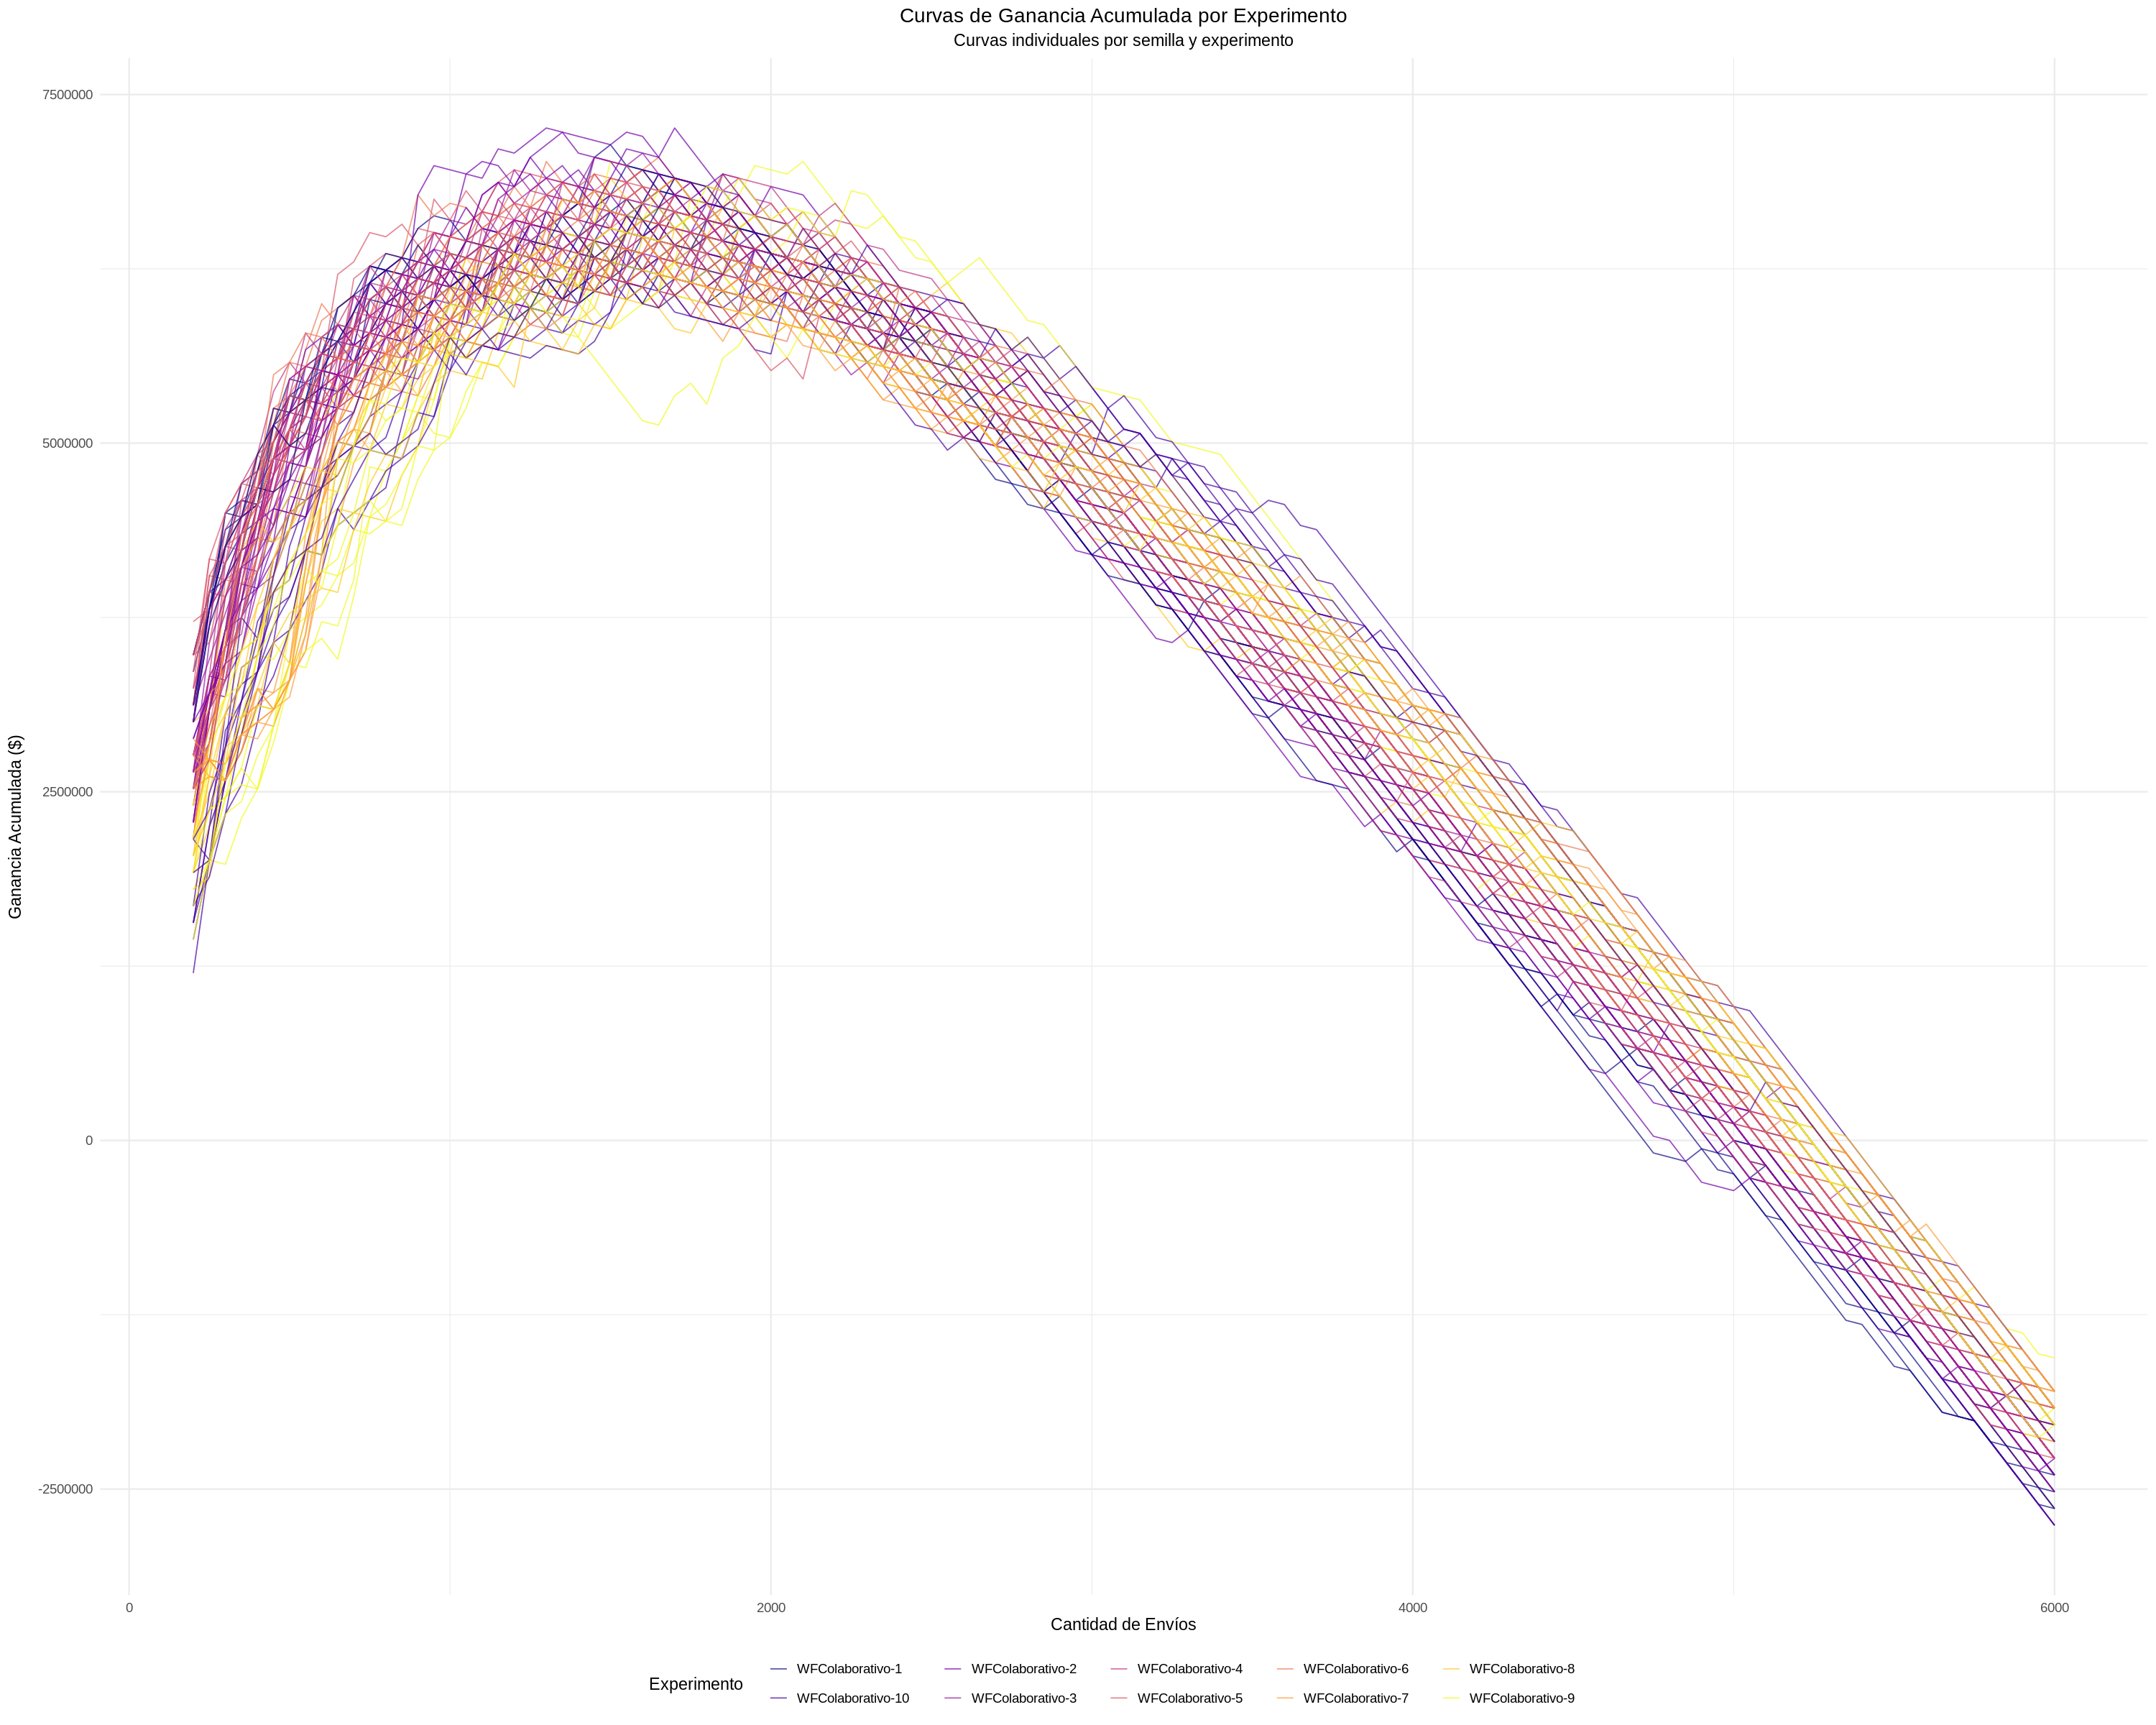

In [ ]:
ggplot(curvas, aes(x = envios, y = Ganancia_acum, color = exp, group = interaction(exp, semilla))) +
  geom_line(alpha = 0.7) +
  scale_color_viridis_d(option = "C") +
  labs(
    title = "Curvas de Ganancia Acumulada por Experimento",
    subtitle = "Curvas individuales por semilla y experimento",
    x = "Cantidad de Envíos",
    y = "Ganancia Acumulada ($)",
    color = "Experimento"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5),
    plot.subtitle = element_text(hjust = 0.5),
    legend.position = "bottom"
  )

## Wilcoxon

In [ ]:
cutoff_envios <- 2000

In [ ]:
paired_data <- curvas[envios == cutoff_envios & grepl("^WFColaborativo-", exp)]
wide_data <- dcast(paired_data, semilla ~ exp, value.var = "Ganancia_acum")
paired_data <- wide_data
target <- "WFColaborativo-1" #comparamos con el experimento que incluye todos los meses, incluso la pandemia
otros <- setdiff(names(paired_data), c("semilla", target))

resultados <- data.table(
  Comparacion = character(),
  p_value = numeric()
)

for (exp in otros) {
  test <- suppressWarnings(
    wilcox.test(paired_data[[target]], paired_data[[exp]], paired = TRUE)
  )

  resultados <- rbind(resultados, data.table(
    Comparacion = paste0(target, " vs ", exp),
    p_value = test$p.value
  ))
}

resultados[, `:=` (
  Comparacion = gsub("WFColaborativo-", "", Comparacion),
  p_value = round(p_value, 4),
  Significativo = ifelse(p_value < 0.05, "✔️ Sí", "❌ No")
)]

resultados <- resultados[order(p_value)]
print(resultados)


   Comparacion p_value Significativo
        <char>   <num>        <char>
1:      1 vs 7  0.0196          ✔️ Sí
2:     1 vs 10  0.1212         ❌ No
3:      1 vs 6  0.1390         ❌ No
4:      1 vs 2  0.1593         ❌ No
5:      1 vs 8  0.2349         ❌ No
6:      1 vs 5  0.5721         ❌ No
7:      1 vs 4  0.6364         ❌ No
8:      1 vs 3  0.8564         ❌ No
9:      1 vs 9  1.0000         ❌ No


**Sólo resulta significativa la diferencia de ganancia entre el experimento 1 y el experimento 7 (aún no sabemos cuál es mejor).**

Agregar más meses no garantiza mejor desempeño, ni siquiera diferencia estadísticamente significativa.

In [ ]:
curvas_1<- curvas[envios == 2000 & exp %in% c("WFColaborativo-1","WFColaborativo-2","WFColaborativo-3","WFColaborativo-4","WFColaborativo-6","WFColaborativo-7", "WFColaborativo-8",
"WFColaborativo-9","WFColaborativo-10")]

resumen <- curvas_1[, .(
  media = mean(Ganancia_acum, na.rm = TRUE)), by = exp]

print(resumen)


                 exp   media
              <char>   <num>
1:  WFColaborativo-1 6324000
2: WFColaborativo-10 6144000
3:  WFColaborativo-2 6408000
4:  WFColaborativo-3 6324000
5:  WFColaborativo-4 6372000
6:  WFColaborativo-6 6180000
7:  WFColaborativo-7 6048000
8:  WFColaborativo-8 6216000
9:  WFColaborativo-9 6348000


**Quitar los últimos meses, empeora la ganancia.**

# **¿Será que consideramos pocas semillas?**

Inicialmente generamos los resultados con 10 semillas para cada experimento, aumentamos el número de semillas, para ver si los resultados coinciden.

In [ ]:
carpetas <- list.dirs(path = base_path, recursive = FALSE, full.names = TRUE)

# Incluir solo las carpetas que contienen "Colaborativo" y "bis"
carpetas <- carpetas[grepl("Colaborativo", carpetas) & grepl("bis", carpetas)]

In [ ]:
resultados <- list()

In [ ]:
for (carpeta in carpetas) {
  archivos <- list.files(path = carpeta, pattern = "^prediccion_\\d+\\.txt$", full.names = TRUE)

  for (archivo in archivos) {
    pred <- fread(archivo)
    pred <- pred[order(-prob)]

    pred[, Ganancia := ifelse(clase_ternaria == "BAJA+2", 117000, -3000)]
    pred[, Ganancia_acum := cumsum(Ganancia)]

    cortes <- seq(200, 6000, 50)
    pred_cortes <- pred[cortes, .(envios = cortes, Ganancia_acum)]

    pred_cortes[, semilla := str_extract(basename(archivo), "\\d+")]
    pred_cortes[, exp := basename(carpeta)]

    resultados[[length(resultados) + 1]] <- pred_cortes
  }
}

# Combinar resultados
curvas <- rbindlist(resultados)

In [ ]:
cutoff_envios <- 2000

In [ ]:
paired_data <- curvas[envios == cutoff_envios & grepl("^WFColaborativo-", exp)]
wide_data <- dcast(paired_data, semilla ~ exp, value.var = "Ganancia_acum")
paired_data <- wide_data
target <- "WFColaborativo-1bis" #comparamos con el experimento que incluye todos los meses, incluso la pandemia
otros <- setdiff(names(paired_data), c("semilla", target))

resultados <- data.table(
  Comparacion = character(),
  p_value = numeric()
)

for (exp in otros) {
  test <- suppressWarnings(
    wilcox.test(paired_data[[target]], paired_data[[exp]], paired = TRUE)
  )

  resultados <- rbind(resultados, data.table(
    Comparacion = paste0(target, " vs ", exp),
    p_value = test$p.value
  ))
}

resultados[, `:=` (
  Comparacion = gsub("WFColaborativo-", "", Comparacion),
  p_value = round(p_value, 4),
  Significativo = ifelse(p_value < 0.05, "✔️ Sí", "❌ No")
)]

resultados <- resultados[order(p_value)]
print(resultados)


     Comparacion p_value Significativo
          <char>   <num>        <char>
1: 1bis vs 10bis  0.0003          ✔️ Sí
2:  1bis vs 3bis  0.0090          ✔️ Sí
3:  1bis vs 9bis  0.0799         ❌ No
4:  1bis vs 8bis  0.1366         ❌ No
5:  1bis vs 2bis  0.1543         ❌ No


In [ ]:
curvas_1_10 <- curvas[envios == 2000 & exp %in% c("WFColaborativo-1bis", "WFColaborativo-10bis")]

resumen <- curvas_1_10[, .(
  media = mean(Ganancia_acum, na.rm = TRUE),
  mediana = median(Ganancia_acum, na.rm = TRUE)
), by = exp]

print(resumen)

                    exp   media mediana
                 <char>   <num>   <num>
1: WFColaborativo-10bis 6174000 6240000
2:  WFColaborativo-1bis 6474000 6480000


In [ ]:
curvas_1_3 <- curvas[envios == 2000 & exp %in% c("WFColaborativo-1bis", "WFColaborativo-3bis")]

resumen <- curvas_1_3[, .(
  media = mean(Ganancia_acum, na.rm = TRUE),
  mediana = median(Ganancia_acum, na.rm = TRUE)
), by = exp]

print(resumen)

                   exp   media mediana
                <char>   <num>   <num>
1: WFColaborativo-1bis 6474000 6480000
2: WFColaborativo-3bis 6294000 6240000


In [ ]:
paired_data <- curvas[envios == cutoff_envios & grepl("^WFColaborativo-", exp)]
wide_data <- dcast(paired_data, semilla ~ exp, value.var = "Ganancia_acum")
paired_data <- wide_data
target <- "WFColaborativo-9bis" #comparamos con el experimento que incluye todos los meses, incluso la pandemia
otros <- setdiff(names(paired_data), c("semilla", target))

resultados <- data.table(
  Comparacion = character(),
  p_value = numeric()
)

for (exp in otros) {
  test <- suppressWarnings(
    wilcox.test(paired_data[[target]], paired_data[[exp]], paired = TRUE)
  )

  resultados <- rbind(resultados, data.table(
    Comparacion = paste0(target, " vs ", exp),
    p_value = test$p.value
  ))
}

resultados[, `:=` (
  Comparacion = gsub("WFColaborativo-", "", Comparacion),
  p_value = round(p_value, 4),
  Significativo = ifelse(p_value < 0.05, "✔️ Sí", "❌ No")
)]

resultados <- resultados[order(p_value)]
print(resultados)


     Comparacion p_value Significativo
          <char>   <num>        <char>
1: 9bis vs 10bis  0.0364          ✔️ Sí
2:  9bis vs 1bis  0.0799         ❌ No
3:  9bis vs 8bis  0.1802         ❌ No
4:  9bis vs 3bis  0.5852         ❌ No
5:  9bis vs 2bis  1.0000         ❌ No


In [ ]:
curvas_1_9 <- curvas[envios == 2000 & exp %in% c("WFColaborativo-1bis", "WFColaborativo-9bis")]

resumen <- curvas_1_9[, .(
  media = mean(Ganancia_acum, na.rm = TRUE),
  mediana = median(Ganancia_acum, na.rm = TRUE)
), by = exp]

print(resumen)

                   exp   media mediana
                <char>   <num>   <num>
1: WFColaborativo-1bis 6474000 6480000
2: WFColaborativo-9bis 6354000 6360000


# *Ganancias en Kaggle*

In [ ]:
exp1 <- c(3962, 3783, 3654, 3902, 3743, 3584, 3843, 3704, 3584, 3416, 3634)
exp2 <- c(3634, 3535, 3763, 4339, 4280, 4498, 4746, 4587, 4438, 4687, 4578)
exp3 <- c(3723, 3485, 3603, 3932, 3753, 3664, 3793, 3952, 4081, 3872, 4031)
exp4 <- c(3306, 3455, 3634, 3763, 3922, 4101, 3922, 3674, 4793, 3128, 2850)
exp5 <- c(3634, 3465, 3326, 3187, 3068, 2840, 2979, 3962, 3843, 4468, 4369)
exp6 <- c(2790, 3018, 3316, 3565, 3426, 3316, 3535, 3426, 3227, 3525, 3386)
exp9 <- c(3336, 3108, 2850, 2572, 2720, 2929, 3108, 3197, 2502, 2711, 2830)



In [ ]:
experimentos <- list(exp2=exp2, exp3=exp3, exp4=exp4, exp5=exp5, exp6=exp6, exp9=exp9)

diferentes <- list()

for (nombre in names(experimentos)) {
  test <- wilcox.test(exp1, experimentos[[nombre]], paired = TRUE)
  cat(nombre, ": p-value =", test$p.value, "\n")
  if (test$p.value < 0.05) {
    diferentes[[nombre]] <- experimentos[[nombre]]
  }
}


exp2 : p-value = 0.009765625 
exp3 : p-value = 0.3203125 
exp4 : p-value = 0.6376953 


Warning message in wilcox.test.default(exp1, experimentos[[nombre]], paired = TRUE):
“cannot compute exact p-value with ties”


exp5 : p-value = 0.3502908 
exp6 : p-value = 0.001953125 


Warning message in wilcox.test.default(exp1, experimentos[[nombre]], paired = TRUE):
“cannot compute exact p-value with ties”


exp9 : p-value = 0.0038398 


In [ ]:
media_exp1 <- mean(exp1)
cat("\nMedia de exp1:", media_exp1, "\n")

for (nombre in names(diferentes)) {
  media <- mean(diferentes[[nombre]])
  cat("Media de", nombre, ":", media, "\tDiferencia:", media - media_exp1, "\n")
}



Media de exp1: 3709.909 
Media de exp2 : 4280.455 	Diferencia: 570.5455 
Media de exp6 : 3320.909 	Diferencia: -389 
Media de exp9 : 2896.636 	Diferencia: -813.2727 
